In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})




/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [4]:
weather = pd.read_csv("allweather_cp2.csv")


In [5]:
year = []
month = []
day = []
for i in weather.DATE:
    year.append(int(str(i)[0:4]))
    day.append(int(str(i)[6:]))
    month.append(int(str(i)[4:6]))



In [6]:
weather2 = pd.DataFrame()
weather2["Year"] = year
weather2["Month"] = month
weather2["Day"] = day
weather2["precip"] = weather.PRCP
weather2["temp_max"] = weather.TMAX
weather2["temp_min"] = weather.TMIN
print type(weather2.Year[0])
print type(weather2.Month[0])
print type(weather2.Day[0])

<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>


In [7]:
df = pd.read_csv("Day_Month_Year_Count.csv")
df = pd.read_csv("Day_Month_Year_Count_wd.csv")
df = df.drop(df.columns[0:2],1)
df = df.drop("mdy",1)


df = df.sort_values(["Year","Month","Day"],ascending=True)
df = df.reset_index(drop = True)
df.shape
print type(df.Year[0])
print type(df.Month[0])
print type(df.Day[0])
#print df2.shape

<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>


In [8]:
df_int = pd.merge(weather2, df, how='inner',on=['Year', 'Month','Day'])


In [9]:
maxi = 6
for i in range(1,maxi):
    newcol = "Day_Lag_" + str(i)
    df_int[newcol] = np.roll(df_int["count"],i)
    
maxi = 6
for i in range(1,maxi):
    newcol = "Day_Lag_" + str(i)
    df[newcol] = np.roll(df["count"],i)

In [10]:
df1 = df.drop(["Day","Month","Year","wd","count"],1)


In [11]:
df2 = df_int.drop(range(0,maxi),0)


labels = df2.ix[:,"count"]
labels = labels.reset_index(drop = True)
df2 = df2.drop(["count","Year"],1)
df2 = df2.reset_index(drop = True)
df2_int = df2
df2["Month"]  = df2["Month"].astype(str)
df2 = pd.get_dummies(df2,"Month")

df3 = df2
df2 = df2.drop("Day",1)
df2 = df2.drop("wd",1)





df3["Change1"] = (df2.Day_Lag_1 - df2.Day_Lag_2)
df3["Change2"] = (df2.Day_Lag_2 - df2.Day_Lag_3)
df3["Change3"] = (df2.Day_Lag_3 - df2.Day_Lag_4)

df4  = df3
df3 = df3.drop(["wd","Day"],1)



df4["wd"]  = df4["wd"].astype(str)
df4 = pd.get_dummies(df4,"wd")


# df2_int["Change1"] = (df2.count1 - df2.count2)
# df2_int["Change2"] = (df2.count2 - df2.count3)
# df2_int["Change3"] = (df2.count3 - df2.count4)

df2_int["Change1"] = (df2.Day_Lag_1 - df2.Day_Lag_2)
df2_int["Change2"] = (df2.Day_Lag_2 - df2.Day_Lag_3)
df2_int["Change3"]  = (df2.Day_Lag_3 - df2.Day_Lag_4)



df2_int["wd"]  = df2_int["wd"].astype(str)
df2_int = pd.get_dummies(df2_int,"wd")
df2_int = df2_int.drop("Day",1)



In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def model_rms_preds(dataframe,trees):
    rg = RandomForestRegressor(n_jobs=-1,n_estimators=trees, random_state = 1)
    preds = []
    rmsl = []
    rmsl2 = []
    #for i in range(1,df2.shape[0]-1):
    start = dataframe.shape[0]-200
    end = dataframe.shape[0]-20
    scores = []
    for i in range(start,end):
        train = dataframe.iloc[0:i,:]
        tr_labels = labels[0:i]
        test = dataframe.iloc[i,:]
        rg.fit(train,tr_labels)
        #print test
        preds.append(rg.predict(test)[0])
        #scores.append(rg.score(test,labels[i]))
        actuals = labels[start:i+1]
        if i == start:
            pass
        else:
            #rms = np.sqrt(mean_squared_error(actuals[:-1], preds[1:]))
            #rmsl.append(rms)
            rms = np.sqrt(mean_squared_error(actuals, preds))
            rmsl.append(rms)


            #rmsl2.append(np.sqrt(mean_squared_error(labels.iloc[i],rg.predict(test)[0])))
        if i%100 == 0:
            print i
    #print "final_test_point",test
    #print "Final_Prediction", rg.predict(test)[0]
    return rg,rmsl,preds,actuals,train



In [15]:
end = df2.shape[0]-20
train = df.iloc[0:end,:]


In [16]:
def import_plotter(rg,train,title,ylab):
    importances = rg.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rg.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    title = title
    # Print the feature ranking
#     print("Feature ranking:")
#     X = train
#     for f in range(X.shape[1]):
#         print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    X = train
    
    plt.figure()
    plt.title(title)
    plt.ylabel(ylab)
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), train.columns[indices], rotation='vertical')

    plt.xlim([-1, X.shape[1]])
    plt.savefig(title + "png")
    plt.show()
    


In [17]:
trees = 200
rg1,rmsl1,preds1,actuals1,train1 = model_rms_preds(df1,trees)



2100
2200


In [18]:
rg2,rmsl2,preds2,actuals2,train2 = model_rms_preds(df2,trees)


2100
2200


In [19]:
rg3,rmsl3,preds3,actuals3,train3 = model_rms_preds(df3,trees)



2100
2200


In [20]:
rg4,rmsl4,preds4,actuals4,train4 = model_rms_preds(df4,trees)


2100
2200


In [21]:
ran = range(df.shape[0]-210,df.shape[0])
x = range(len(rmsl3))
#ran = df.shape[0]-100 :df.shape[0]-20
dates = train.Month.astype(str)+ "/"+train.Day.astype(str) + "/"+train.Year.astype(str)


a = dates[ran]
a = a.sort_index()
a =a.reset_index(drop = True)[x]
a = np.array(a)
len(a)

179

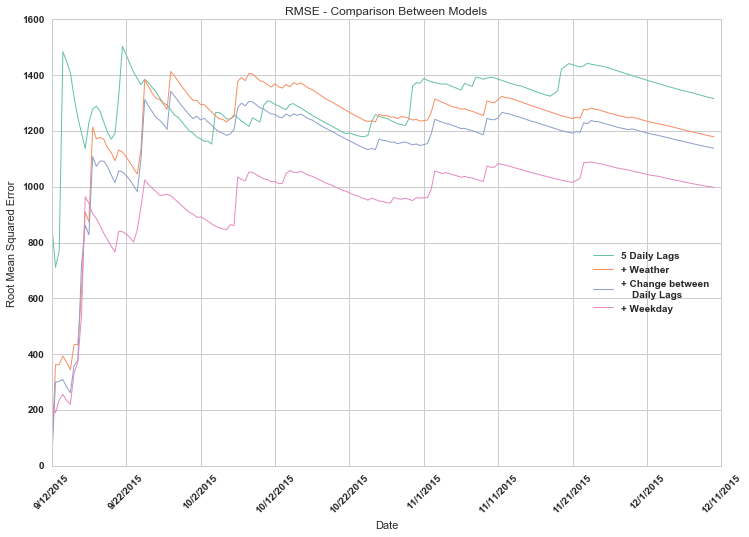

In [69]:
import seaborn as sns
current_palette = sns.color_palette("Set2", 10)
sns.set_style("whitegrid", {'axes.grid' : True})



linewidth = 1

fig = plt.figure(dpi=500)
fig.set_size_inches(12, 8)
ax = fig.add_subplot(111)
line1 = ax.plot(x,rmsl1,label = "5 Daily Lags", lw=linewidth, color = current_palette[0])
line2 = ax.plot(x,rmsl2,label = "+ Weather", lw=linewidth,color = current_palette[1])
line3 = ax.plot(x,rmsl3,label = "+ Change between \n    Daily Lags", lw=linewidth,color = current_palette[2])
line4 = ax.plot(x,rmsl4,label = "+ Weekday", lw=linewidth,color = current_palette[3])

plt.xticks(x[::10],a[::10], rotation= 45)


max_yticks = 10
yloc = plt.MaxNLocator(max_yticks)
ax.xaxis.set_major_locator(yloc)



ax.legend(bbox_to_anchor=(1, 0.5),fontsize = 10)
plt.title("RMSE - Comparison Between Models")
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Date")
plt.savefig("figs/RMSE.png",dpi=300)

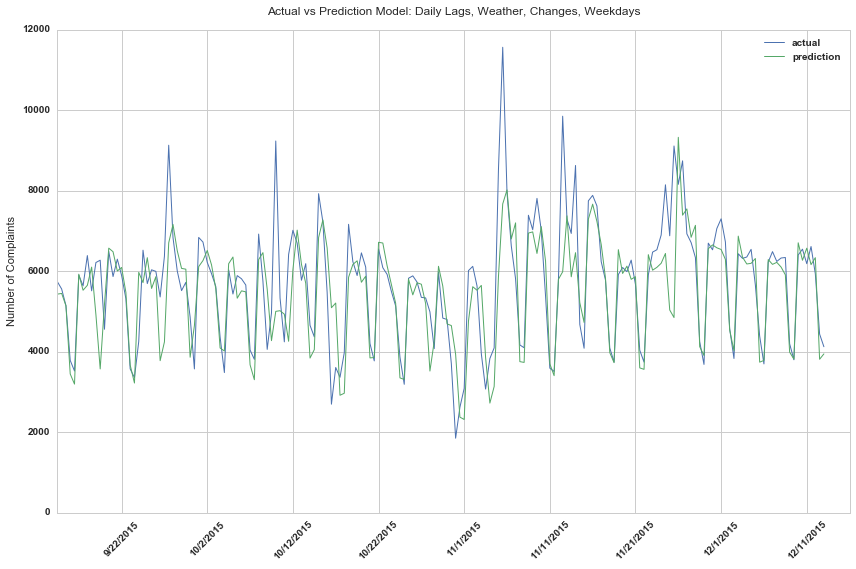

In [42]:
fig = plt.figure(dpi=300)
linewidth = 1
fig.set_size_inches(12, 8)
ax = fig.add_subplot(111)
line1 = ax.plot(actuals4,label = "actual",lw = linewidth)
#line2 = ax.plot(actuals.index.values[:-1],preds[1:],label = "prediction")
line2 = ax.plot(actuals4.index.values,preds4,label = "prediction",lw = linewidth)
ax.legend(bbox_to_anchor=(1, 1))
plt.xlim(2085,2270)
#plt.xticks(actuals4.index.values,a, rotation= 45)

plt.xticks(actuals4.index.values[::10],a[::10], rotation= 45)

max_yticks = 10
yloc = plt.MaxNLocator(max_yticks)
ax.xaxis.set_major_locator(yloc)

#print len(preds3)
plt.title("Actual vs Prediction Model: Daily Lags, Weather, Changes, Weekdays", y=1.02)
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.savefig("figs/Predictions.png",dpi=300)

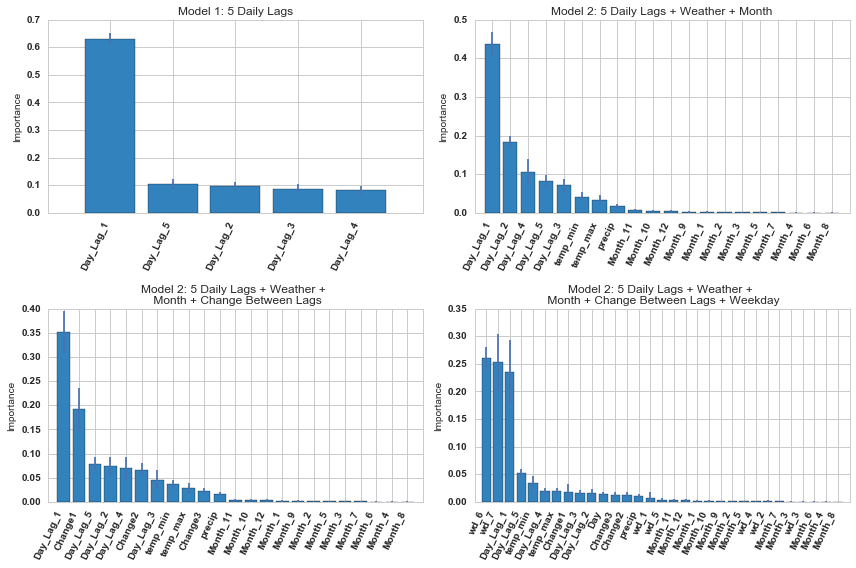

In [65]:
#a = import_plotter(rg1,train1,"Initial")

col = "#3182bd"
ylab_size = 10
title_size = 12
ticksize = 10
fig = plt.figure()
fig.set_size_inches(12, 8)
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)



############################################################
importances = rg1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rg1.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
plottitle = "Model 1: 5 Daily Lags"
X = train1
ylab = "Importance"

plt.subplot(2, 2, 1)

plt.bar(range(X.shape[1]), importances[indices],color=col, yerr=std[indices], align="center")
plt.title(plottitle,fontsize = title_size)
plt.ylabel(ylab,fontsize=ylab_size)
plt.xticks(range(X.shape[1]), X.columns[indices], rotation= 65, ha = "right")

plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.7)
plt.tick_params(axis="x", labelsize=ticksize)



############################################################
importances = rg2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rg2.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
plt.subplot(2, 2, 2)
plottitle = "Model 2: 5 Daily Lags + Weather + Month"
X = train2
ylab = "Importance"
ax2.bar(range(X.shape[1]), importances[indices],color=col, yerr=std[indices], align="center")
plt.title(plottitle,fontsize = title_size)
plt.ylabel(ylab,fontsize = ylab_size)
plt.xticks(range(X.shape[1]), X.columns[indices], rotation= 65, ha = "right")

plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.5)
plt.tick_params(axis="x", labelsize=ticksize)




############################################################
importances = rg3.feature_importances_
std = np.std([tree.feature_importances_ for tree in rg3.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
plt.subplot(2, 2, 3)
plottitle = "Model 2: 5 Daily Lags + Weather + \n Month + Change Between Lags"

X = train3
ylab = "Importance"

##
ax3.bar(range(X.shape[1]), importances[indices],color=col, yerr=std[indices], align="center")
plt.title(plottitle,fontsize = title_size)
plt.ylabel(ylab,fontsize=ylab_size)

##
plt.xticks(range(X.shape[1]), X.columns[indices], rotation= 65, ha = "right")

plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.4)
plt.tick_params(axis="x", labelsize=ticksize)

############################################################
importances = rg4.feature_importances_
std = np.std([tree.feature_importances_ for tree in rg4.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
plt.subplot(2, 2, 4)
plottitle = "Model 2: 5 Daily Lags + Weather + \n Month + Change Between Lags + Weekday"

X = train4
ylab = "Importance"
ax4.bar(range(X.shape[1]), importances[indices],color=col, yerr=std[indices], align="center")
plt.title(plottitle,fontsize = title_size)
plt.ylabel(ylab,fontsize=ylab_size)
plt.xticks(range(X.shape[1]), X.columns[indices], rotation= 65, ha = "right")
plt.tick_params(axis="x", labelsize=ticksize)

plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.35)
#plt.rc('font', weight='bold')


plt.tight_layout()

plt.savefig("figs/Importance.png",dpi=300)
